# CMSC5702 (Advanced Topics in Parallel / Distributed Systems)
# Assignment 1: Parallel Programming with Sobel Filter


## Objective

Apply the Sobel filter for edge detection on **large square grayscale images** using MPI and OpenMP, and compare the performance of shared-memory vs distributed-memory parallelization. Optionally, include a blurring step to reduce noise before applying the Sobel operator.

This assignment allows you to practice:

* Sequential programming
* OpenMP parallelization on shared-memory systems
* MPI parallelization on distributed-memory systems
* Performance measurement, verification, and speedup analysis

---

## Problem Description

The **Sobel filter** computes approximate image gradients to detect edges. For a grayscale image (I):

$$
G_x =
\begin{bmatrix}
-1 & 0 & 1 \\
-2 & 0 & 2 \\
-1 & 0 & 1
\end{bmatrix} * I, \quad
G_y =
\begin{bmatrix}
-1 & -2 & -1 \\
0 & 0 & 0 \\
1 & 2 & 1
\end{bmatrix} * I
$$

The **gradient magnitude** at each pixel is:

$$
G = \sqrt{G_x^2 + G_y^2}
$$
Optional **blurring step**: compute the local average of pixels in a small neighborhood (e.g., 3×3) before applying the Sobel operator to reduce noise.


# Part 1: Sequential Version

- Implement a standard sequential C program to apply the Sobel operator on a grayscale image.
- If including blurring, apply an average filter first (e.g., 3×3 kernel) before Sobel.


#### Question: Explain the algorithm you implemented and if you applyed blurring, explain the blurring method.

#### Your Answer:


My implementation follows a two-stage process.

First, I implemented the optional **blurring step** to reduce image noise before edge detection. The method I used is the **$3 \times 3$ average filter**, which is also called a mean filter. As shown in my `blur_filter` function, this filter works by sliding a 3x3 window over the image. For each pixel, it calculates the average value of all 9 pixels in its $3 \times 3$ neighborhood (summing them up and dividing by 9.0) and uses this average as the new value for that pixel.

Second, I apply the **Sobel operator** to the *blurred* image. This is implemented in my `sobel_filter` function. This algorithm calculates two gradients for each pixel by convolving the image with two 3x3 kernels:
* $G_x$: Using the 3x3 Sobel kernel to detect horizontal changes.
* $G_y$: Using the 3x3 Sobel kernel to detect vertical changes.

Finally, the magnitude of the gradient is computed using the formula $G = \sqrt{G_x^2 + G_y^2}$ to get the final pixel intensity for the edge-detected image. In my implementation, for pixels on the 1-pixel border of the image, I set their output value to 0.0, as the 3x3 kernel cannot be fully applied there.

In [12]:
!pip install pandas

In [13]:
!pip install matplotlib

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

seq_df = pd.read_csv("sequential_times.csv")

In [15]:
seq_df

,image_size,run1_time,run2_time,run3_time
0,256,0.000933,0.001047,0.000888
1,1024,0.015544,0.014636,0.014826
2,4000,0.210384,0.194488,0.215198
3,16000,4.079864,3.984604,3.932855


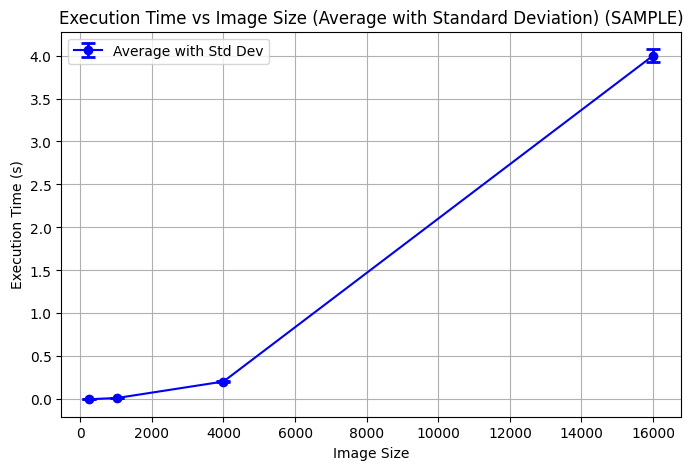

Data with averages and standard deviations:
   image_size  average_time   std_dev
0         256      0.000956  0.000082
1        1024      0.015002  0.000479
2        4000      0.206690  0.010838
3       16000      3.999108  0.074570


In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Assuming your data is in a DataFrame called df
# Calculate average and standard deviation
seq_df['average_time'] = seq_df[['run1_time', 'run2_time', 'run3_time']].mean(axis=1)
seq_df['std_dev'] = seq_df[['run1_time', 'run2_time', 'run3_time']].std(axis=1)

# Plot with error bars showing standard deviation
plt.figure(figsize=(8,5))
plt.errorbar(seq_df['image_size'], seq_df['average_time'], 
             yerr=seq_df['std_dev'], 
             marker='o', 
             color='blue', 
             label='Average with Std Dev',
             capsize=5,  # Adds caps to the error bars
             capthick=2,
             elinewidth=2)

plt.xlabel('Image Size')
plt.ylabel('Execution Time (s)')
plt.title('Execution Time vs Image Size (Average with Standard Deviation) (SAMPLE)')
plt.legend()
plt.grid(True)
plt.show()

# Optional: Print the calculated values
print("Data with averages and standard deviations:")
print(seq_df[['image_size', 'average_time', 'std_dev']])

# Part 2: OpenMP Programming

- Use\#pragma omp parallel for collapse(2) for nested loops.
- Experiment with schedule(static) and other scheduling clauses.
- Process large images in tiles (e.g., 512×512 or 1024×1024) to reduce memory bandwidth issues.
- [Bonus Point] Optionally include a blurring step before the Sobel operator to reduce noise. 


#### Question: Explain the algorithm you implemented and if you applyed blurring, explain the blurring method.

#### Your Answer:



For the OpenMP implementation, my algorithm follows the same two-stage process as the sequential version, but the parallelization strategy is optimized for cache performance.

I implemented the **blurring step**. The method is the **$3 \times 3$ average filter**, where each pixel's new value is the average of its 9-pixel neighborhood (summing them up and dividing by 9.0) to reduce noise.

The core of my parallel implementation is a **tiling (or block-based) decomposition**.Here is the logic:

1.  **Tiling:** Instead of parallelizing the image row by row, I divide the entire image into small, fixed-size square blocks.

2.  **Parallelism:** I use OpenMP's `#pragma omp parallel for collapse(2)` directive. This directive assigns *entire tiles* to different threads. The `collapse(2)` tells OpenMP to merge the two outer loops (the one iterating tile rows and the one iterating tile columns) into one large loop, which provides many independent tasks (the tiles) for the threads to work on.

This tiling method is applied to both functions:
* First, `blur_filter_tiled` runs, with threads processing different tiles to create the blurred image.
* Second, `sobel_filter_tiled` runs on the blurred image, using the exact same parallel tiling strategy. Inside each tile, the standard Sobel logic is applied (convolving with Gx and Gy kernels, then calculating the magnitude $G = \sqrt{G_x^2 + G_y^2}$).

Processing the image in tiles ensures that the data a thread is working on (a single tile) is small enough to fit well within the CPU caches, which reduces memory bandwidth issues and improves performance, especially on large images.

In [17]:
omp_df = pd.read_csv("openmp_times.csv")

In [18]:
omp_df.head()

,image_size,threads,run1_time,run2_time,run3_time
0,256,1,0.002602,0.002662,0.002512
1,256,2,0.002633,0.002648,0.002686
2,256,4,0.002697,0.002705,0.002729
3,256,8,0.002934,0.002855,0.002830
4,256,16,0.003115,0.003054,0.003121


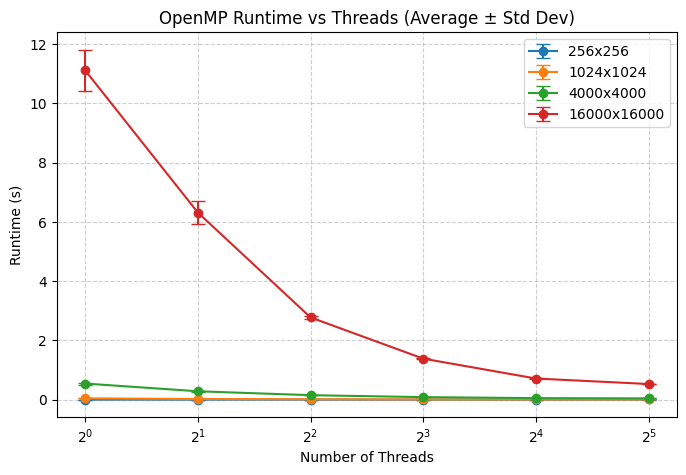

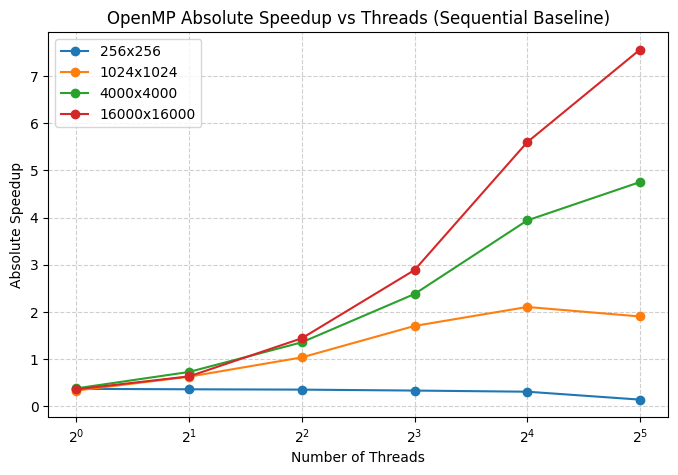

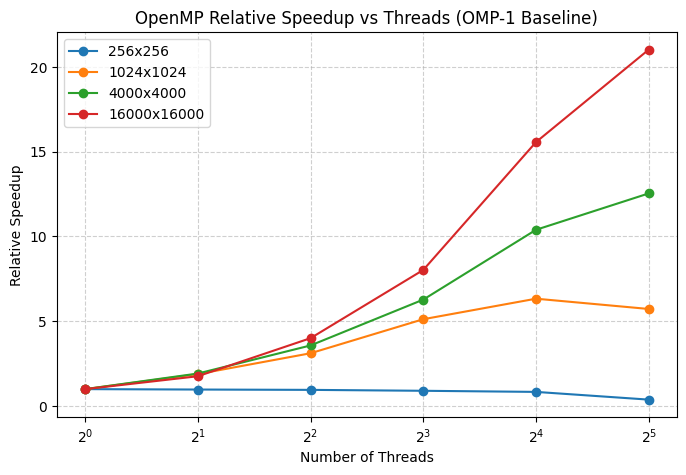

OpenMP data with runtime, std_dev, absolute and relative speedups:
    image_size  threads  average_time   std_dev  absolute_speedup  \
0          256        1      0.002592  0.000075          0.368827   
1          256        2      0.002656  0.000027          0.359985   
2          256        4      0.002710  0.000017          0.352724   
3          256        8      0.002873  0.000054          0.332753   
4          256       16      0.003097  0.000037          0.308719   
5          256       32      0.006793  0.000634          0.140726   
6         1024        1      0.045112  0.001055          0.332548   
7         1024        2      0.023913  0.002435          0.627358   
8         1024        4      0.014483  0.000557          1.035811   
9         1024        8      0.008809  0.000231          1.703095   
10        1024       16      0.007126  0.000275          2.105347   
11        1024       32      0.007880  0.000090          1.903807   
12        4000        1      0.54505

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 如果未预先加载 OpenMP 数据，则从报告目录读取
try:
    omp_df
except NameError:
    omp_df = pd.read_csv("openmp_times.csv")  # 关键：确保读取的是 report/openmp_times.csv

# 读取顺序版本数据，用作“绝对加速比”的基线
seq_df = pd.read_csv("sequential_times.csv")  # 关键：确保读取的是 report/sequential_times.csv
seq_df['average_time'] = seq_df[['run1_time','run2_time','run3_time']].mean(axis=1)  # 顺序版本的平均时间

# 计算 OpenMP 各线程的平均时间与标准差
omp_df['average_time'] = omp_df[['run1_time','run2_time','run3_time']].mean(axis=1)
omp_df['std_dev'] = omp_df[['run1_time','run2_time','run3_time']].std(axis=1)

# 预先创建加速比列
omp_df['absolute_speedup'] = 0.0
omp_df['relative_speedup'] = 0.0

# 计算绝对/相对加速比
# 绝对加速比：顺序实现平均时间 / 当前并行平均时间
# 相对加速比：OpenMP 1线程平均时间 / 当前并行平均时间
for size in omp_df['image_size'].unique():
    # 从顺序数据中取出对应 image_size 的平均时间，作为绝对加速比基线
    seq_time = seq_df.loc[seq_df['image_size'] == size, 'average_time'].iloc[0]
    # 从 OpenMP 数据中取出 1 线程的平均时间，作为相对加速比基线
    omp1_time = omp_df[(omp_df['image_size'] == size) & (omp_df['threads'] == 1)]['average_time'].iloc[0]
    
    subset_idx = omp_df[omp_df['image_size'] == size].index
    # 绝对加速比
    omp_df.loc[subset_idx, 'absolute_speedup'] = seq_time / omp_df.loc[subset_idx, 'average_time']
    # 相对加速比
    omp_df.loc[subset_idx, 'relative_speedup'] = omp1_time / omp_df.loc[subset_idx, 'average_time']

# 绘制运行时间（含标准差误差条）
plt.figure(figsize=(8,5))
for size in sorted(omp_df['image_size'].unique()):
    subset = omp_df[omp_df['image_size'] == size]
    plt.errorbar(subset['threads'], subset['average_time'], 
                 yerr=subset['std_dev'], 
                 marker='o', label=f'{size}x{size}', capsize=5)

plt.xlabel('Number of Threads')
plt.ylabel('Runtime (s)')
plt.title('OpenMP Runtime vs Threads (Average ± Std Dev)')
plt.xscale('log', base=2)
plt.xticks([1,2,4,8,16,32])
plt.grid(True, which='both', linestyle='--', alpha=0.6)
plt.legend()
plt.show()

# 绝对加速比（基线为顺序实现）
plt.figure(figsize=(8,5))
for size in sorted(omp_df['image_size'].unique()):
    subset = omp_df[omp_df['image_size'] == size]
    plt.plot(subset['threads'], subset['absolute_speedup'], marker='o', label=f'{size}x{size}')

plt.xlabel('Number of Threads')
plt.ylabel('Absolute Speedup')
plt.title('OpenMP Absolute Speedup vs Threads (Sequential Baseline)')
plt.xscale('log', base=2)
plt.xticks([1,2,4,8,16,32])
plt.grid(True, which='both', linestyle='--', alpha=0.6)
plt.legend()
plt.show()

# 相对加速比（基线为 OpenMP 1 线程）
plt.figure(figsize=(8,5))
for size in sorted(omp_df['image_size'].unique()):
    subset = omp_df[omp_df['image_size'] == size]
    plt.plot(subset['threads'], subset['relative_speedup'], marker='o', label=f'{size}x{size}')

plt.xlabel('Number of Threads')
plt.ylabel('Relative Speedup')
plt.title('OpenMP Relative Speedup vs Threads (OMP-1 Baseline)')
plt.xscale('log', base=2)
plt.xticks([1,2,4,8,16,32])
plt.grid(True, which='both', linestyle='--', alpha=0.6)
plt.legend()
plt.show()

# 打印核对数据
print("OpenMP data with runtime, std_dev, absolute and relative speedups:")
print(omp_df[['image_size','threads','average_time','std_dev','absolute_speedup','relative_speedup']])

## Part 3: MPI Programming

- Choose a domain decomposition strategy, such as row-wise decomposition, column-wise decomposition, etc., decomposition. Your choice will affect performance, and better-designed decomposition and communication patterns will receive higher marks.
- For each process, you may need to include some approaches to allow seamless computation for the edges.
- [Bonus Point] You can include If a parallelized blurring step and you may need to try to optimize the communications.
- Verify your implementation using small test patterns (5×5 or 10×10) and visually inspect sample images for correctness.


In [20]:
mpi_df = pd.read_csv("mpi_times.csv")

In [21]:
mpi_df.head()

,image_size,nodes,processes,run1_time,run2_time,run3_time
0,256,1,1,0.004786,0.004790,0.004787
1,256,1,2,0.004350,0.004399,0.004302
2,256,1,4,0.002177,0.002183,0.002202
3,256,4,8,0.009898,0.010151,0.009965
4,256,4,16,0.009924,0.009968,0.010641


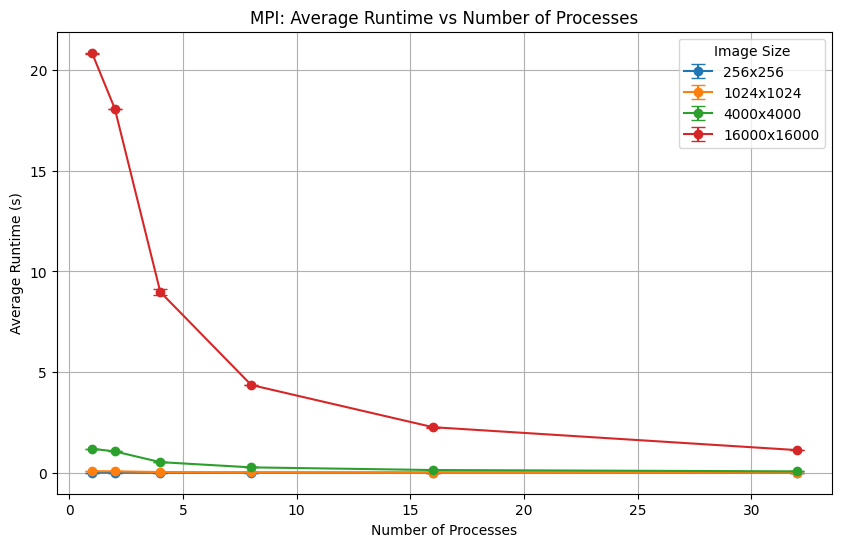

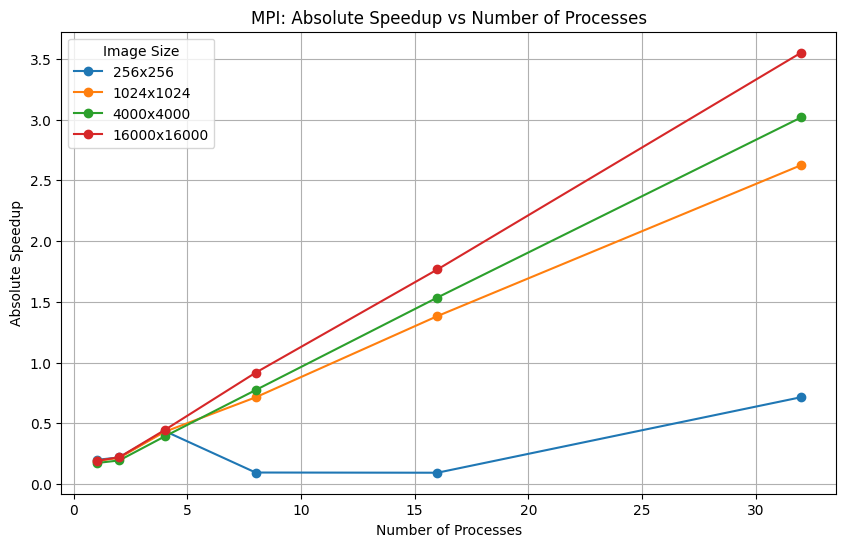

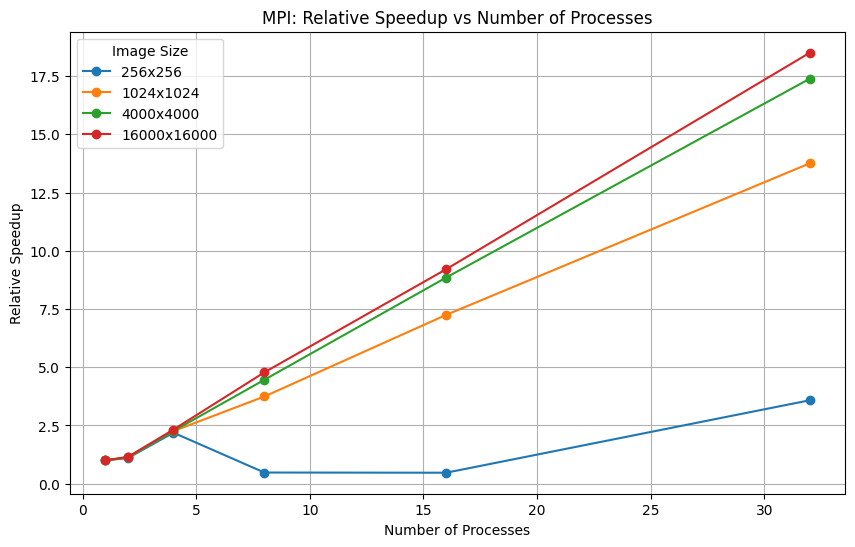

    image_size  nodes  processes  average_time   std_dev  absolute_speedup  \
0          256      1          1      0.004788  0.000002          0.199680   
1          256      1          2      0.004350  0.000049          0.219753   
2          256      1          4      0.002187  0.000013          0.437062   
3          256      4          8      0.010005  0.000131          0.095555   
4          256      4         16      0.010178  0.000402          0.093931   
5          256      4         32      0.001337  0.000314          0.715212   
6         1024      1          1      0.078634  0.000749          0.190783   
7         1024      1          2      0.069275  0.000083          0.216558   
8         1024      1          4      0.034820  0.000068          0.430844   
9         1024      4          8      0.021006  0.000763          0.714166   
10        1024      4         16      0.010849  0.000123          1.382758   
11        1024      4         32      0.005716  0.000160        

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 如未加载数据则读取
try:
    mpi_df
except NameError:
    mpi_df = pd.read_csv("mpi_times.csv")

# 读取顺序数据用于绝对加速比基线
seq_df = pd.read_csv("sequential_times.csv")
seq_df['average_time'] = seq_df[['run1_time','run2_time','run3_time']].mean(axis=1)

# 计算平均时间和标准差
mpi_df['average_time'] = mpi_df[['run1_time', 'run2_time', 'run3_time']].mean(axis=1)
mpi_df['std_dev'] = mpi_df[['run1_time', 'run2_time', 'run3_time']].std(axis=1)

# 绝对加速比 使用顺序实现平均时间作为基线
abs_baseline = {size: t for size, t in zip(seq_df['image_size'], seq_df['average_time'])}
mpi_df['absolute_speedup'] = mpi_df.apply(lambda row: abs_baseline[row['image_size']] / row['average_time'], axis=1)

# 相对加速比 使用1节点1进程平均时间作为基线
rel_baseline = {}
for img_size in mpi_df['image_size'].unique():
    base_time = mpi_df[(mpi_df['image_size']==img_size) & (mpi_df['nodes']==1) & (mpi_df['processes']==1)]['average_time'].iloc[0]
    rel_baseline[img_size] = base_time
mpi_df['relative_speedup'] = mpi_df.apply(lambda row: rel_baseline[row['image_size']] / row['average_time'], axis=1)

# 绘制运行时间
plt.figure(figsize=(10,6))
for img_size in sorted(mpi_df['image_size'].unique()):
    df_img = mpi_df[mpi_df['image_size']==img_size]
    plt.errorbar(df_img['processes'], df_img['average_time'], yerr=df_img['std_dev'],
                 marker='o', capsize=5, label=f'{img_size}x{img_size}')
plt.xlabel('Number of Processes')
plt.ylabel('Average Runtime (s)')
plt.title('MPI: Average Runtime vs Number of Processes')
plt.legend(title='Image Size')
plt.grid(True)
plt.show()

# 绘制绝对加速比
plt.figure(figsize=(10,6))
for img_size in sorted(mpi_df['image_size'].unique()):
    df_img = mpi_df[mpi_df['image_size']==img_size]
    plt.plot(df_img['processes'], df_img['absolute_speedup'], marker='o', label=f'{img_size}x{img_size}')
plt.xlabel('Number of Processes')
plt.ylabel('Absolute Speedup')
plt.title('MPI: Absolute Speedup vs Number of Processes')
plt.legend(title='Image Size')
plt.grid(True)
plt.show()

# 绘制相对加速比
plt.figure(figsize=(10,6))
for img_size in sorted(mpi_df['image_size'].unique()):
    df_img = mpi_df[mpi_df['image_size']==img_size]
    plt.plot(df_img['processes'], df_img['relative_speedup'], marker='o', label=f'{img_size}x{img_size}')
plt.xlabel('Number of Processes')
plt.ylabel('Relative Speedup')
plt.title('MPI: Relative Speedup vs Number of Processes')
plt.legend(title='Image Size')
plt.grid(True)
plt.show()

# 打印数据
print(mpi_df[['image_size','nodes','processes','average_time','std_dev','absolute_speedup','relative_speedup']])